<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2 Jan P. Siegel - Deep Learning

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

In [2]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

RAM Free: 12.6 GB  | Used: 117.9 MB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL/T2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Parte 1


###Actividad 1

In [ ]:
#deal with tensors
import torch   

#handling text data
from torchtext.legacy import data

#Reproducing same results
SEED = 2023

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

fields = [('text',TEXT), ('label', LABEL)]

#loading custom dataset
training_data = data.TabularDataset(path = "/content/drive/MyDrive/DL/T2/SMSSpamCollection.csv", format='csv', fields=fields, skip_header=True)

In [ ]:
# print preprocessed text sample
print(vars(training_data.examples[0]))

{'text': ['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...'], 'label': '0'}


In [ ]:
import random
train_data, valid_data, test_data = training_data.split(split_ratio=[70, 10, 20], random_state = random.seed(1334))
print("Train Data:", len(train_data))
print("Validation Data:", len(valid_data))
print("Test Data:", len(test_data))

Train Data: 3866
Validation Data: 1105
Test Data: 552


In [ ]:
#initialize GloVe embeddings
TEXT.build_vocab(train_data,min_freq=5, vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

In [ ]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
device = "cpu"
#set batch size
BATCH_SIZE = 8

#Load an iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

La idea de implementar un embedding para las palabras es poder pasar de datos en texto a tensores vectoriales numéricos, esto permite expresar las palabras en un formato que les añada riqueza en su descripción semántica (haciendo que palabras similares tengan valores cercanos) y además las haga consumibles por un modelo de aprendizaje automático.

En particular, GloVe no captura solamente las características estadísticas locales como Word2Vec, sino también las (Glo)bales para crear el (Ve)ctor deseado. Para lograr esto,  toma en cuenta relaciones semánticas locales, pero también deriva relaciones semánticas a partir de una matriz de co-ocurrencia, donde se indica qué tan probable es que una palabra aparezca en el contexto de otra. La gracia de GloVe es que puede expresar esta relación en un vector limpiamente con escasa pérdida de información.

###Actividad 2

In [ ]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        self.bidirectional = bidirectional
        #Constructor
        super().__init__()          
        
        # embedding layer (GloVe)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # rnn layer
        self.rnn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        # dense layer 1
        if self.bidirectional:
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
          self.fc = nn.Linear(hidden_dim, 60)
        
        # dense layer 2
        self.act_intermediate = nn.ReLU()
        self.fc2 = nn.Linear(60, output_dim)
        
        # activation function
        # sigmoidal porque softmax da peores resultados
        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        #packed_output, (hidden, cell) = self.lstm(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        if self.bidirectional:
          #concat the final forward and backward hidden state
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)
        activated_outputs = self.act_intermediate(dense_outputs)
        dense_outputs2 = self.fc2(activated_outputs)
        #Final activation function
        outputs = self.act(dense_outputs2)
        
        return outputs

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)

In [ ]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(1629, 100)
  (rnn): RNN(100, 80, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act_intermediate): ReLU()
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 182,381 trainable parameters
torch.Size([1629, 100])


El número de parámetros depende indirectamente del dataset utilizado, si usamos un dataset de texto muy grande y complejo, necesitaremos más dimensiones para obtener un buen embedding, lo que ser reflejará en la cantidad de parámetros de Wxh. Sin embargo, si se mantienen las dimensiones del embedding, la cantidad de parámetros no se verá afectada al cambiar de dataset.

Entonces, podemos ver que se puede reducir la cantidad de parámetros de la red cambiando el embedding usado, por ejemplo si usamos GloVe con 50d (en vez de 100d), tendremos un tensor de 50 dimensiones para capturar las features de cada palabra, en vez de 100 dimensiones para cada palabra. Esto reducirá la cantidad de parámetros entrenables en W_xh, todo lo anterior sin alterar la dimensionalidad de la capa oculta h_t.


In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 120
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the new model
new_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(new_model)
print(f'The new model has {count_parameters(new_model):,} trainable parameters')

classifier(
  (embedding): Embedding(1629, 100)
  (rnn): RNN(100, 120, batch_first=True)
  (fc): Linear(in_features=120, out_features=60, bias=True)
  (act_intermediate): ReLU()
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act): Sigmoid()
)
The new model has 196,861 trainable parameters



Al pasar de 80 a 120 en la dimension de la capa oculta h_t, vemos que la cantidad de parámetros pasa de 182.381 a 196.861, es decir, un aumento de 14.480 parámetros lo que es explicable teniendo en cuenta que un aumento en h_t implica incrementar la cantidad de parámetros para todas las transformaciones del modelo, es decir, para W_hx, W_hh y W_yh. Esto sin duda tiene considerables implicancias en el tamaño paramétrico del modelo.

###Actividad 3

In [ ]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
print("curent device:", device)
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
            try:
              #retrieve text and no. of words
              text, text_lengths = batch.text
              
              #convert to 1d tensor
              predictions = model(text, text_lengths).squeeze()
              
              #compute loss and accuracy
              loss = criterion(predictions, batch.label)
              acc = binary_accuracy(predictions, batch.label)
              
              #keep track of loss and accuracy
              epoch_loss += loss.item()
              epoch_acc += acc.item()
            except Exception:
              pass
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.240 | Train Acc: 91.61%
	Val. Loss: 0.117 |  Val. Acc: 96.88%
Epoch: 2
	Train Loss: 0.099 | Train Acc: 97.16%
	Val. Loss: 0.102 |  Val. Acc: 96.51%
Epoch: 3
	Train Loss: 0.090 | Train Acc: 97.52%
	Val. Loss: 0.071 |  Val. Acc: 97.72%
Epoch: 4
	Train Loss: 0.054 | Train Acc: 98.73%
	Val. Loss: 0.070 |  Val. Acc: 97.60%
Epoch: 5
	Train Loss: 0.044 | Train Acc: 98.92%
	Val. Loss: 0.066 |  Val. Acc: 98.08%
Epoch: 6
	Train Loss: 0.037 | Train Acc: 99.12%
	Val. Loss: 0.094 |  Val. Acc: 97.12%
Epoch: 7
	Train Loss: 0.032 | Train Acc: 99.33%
	Val. Loss: 0.103 |  Val. Acc: 97.24%
Epoch: 8
	Train Loss: 0.032 | Train Acc: 99.20%
	Val. Loss: 0.066 |  Val. Acc: 98.02%
Epoch: 9
	Train Loss: 0.022 | Train Acc: 99.48%
	Val. Loss: 0.078 |  Val. Acc: 96.69%
Epoch: 10
	Train Loss: 0.033 | Train Acc: 99.33%
	Val. Loss: 0.081 |  Val. Acc: 98.08%


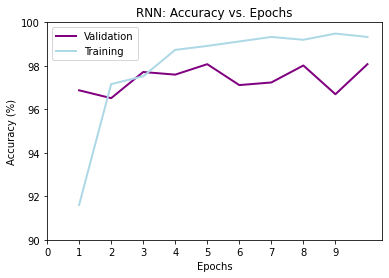

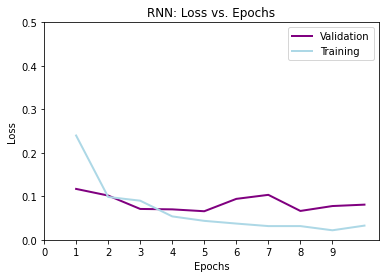

In [ ]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,N_EPOCHS+1), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,N_EPOCHS+1), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.5))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

Podemos ver mediante los gráficos, que la configuración actual demuestra un rendimiento sobre el 98% para el set de entrenamiento y de validación, sin embargo, la pérdida del test de validación sube después de la época 5, mientras que la del test de entrenamiento sigue bajando, lo que indica un caso de overfitting.

In [ ]:
_, test_accuracy = evaluate(model, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  97.64 %


De todas formas, vemos un rendimiento para el set de test de 97.64% , menos de un punto porcentual por debajo del test de validación, lo que demuestra que de todas formas se logró un alto poder de generalización para predecir si los mensajes de texto del dataset corresponden a *spamm* o no.

###Actividad 4

In [ ]:
import torch.nn as nn

class classifier2(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        self.bidirectional = bidirectional
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        if self.bidirectional:
          self.fc = nn.Linear(hidden_dim * 2, 30)
        else:
          self.fc = nn.Linear(hidden_dim, 60)

        self.act0 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(30, output_dim)
        
        #activation function
        self.act1 = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        if self.bidirectional:
          #concat the final forward and backward hidden state
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        x = self.fc(hidden)
        x = self.act0(x)
        x = self.fc2(x)
        #Final activation function
        outputs=self.act1(x)
        
        return outputs

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = False
dropout = 0

#instantiate the lstm model
lstm_model = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional=bidirection, dropout=dropout)
#architecture
print(lstm_model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(lstm_model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
lstm_model.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 100)
  (lstm): LSTM(100, 80, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 226,061 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3196, -0.0119,  0.0098,  ..., -0.0504,  0.2983,  1.3323],
        [ 0.5492,  0.1545, -0.6830,  ..., -1.2155,  0.5693,  1.0440],
        [-0.2009, -0.1691, -0.3587,  ..., -0.3249, -0.3411,  0.2473]])

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(lstm_model.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the lstm_model
    train_loss, train_acc = train(lstm_model, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the lstm_model
    valid_loss, valid_acc = evaluate(lstm_model, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.184 | Train Acc: 93.49%
	Val. Loss: 0.123 |  Val. Acc: 96.22%
Epoch: 2
	Train Loss: 0.064 | Train Acc: 98.04%
	Val. Loss: 0.055 |  Val. Acc: 97.66%
Epoch: 3
	Train Loss: 0.036 | Train Acc: 99.12%
	Val. Loss: 0.051 |  Val. Acc: 97.93%
Epoch: 4
	Train Loss: 0.031 | Train Acc: 99.10%
	Val. Loss: 0.053 |  Val. Acc: 97.93%
Epoch: 5
	Train Loss: 0.025 | Train Acc: 99.20%
	Val. Loss: 0.042 |  Val. Acc: 98.11%
Epoch: 6
	Train Loss: 0.013 | Train Acc: 99.69%
	Val. Loss: 0.045 |  Val. Acc: 98.11%
Epoch: 7
	Train Loss: 0.020 | Train Acc: 99.54%
	Val. Loss: 0.057 |  Val. Acc: 97.75%
Epoch: 8
	Train Loss: 0.012 | Train Acc: 99.72%
	Val. Loss: 0.056 |  Val. Acc: 97.84%
Epoch: 9
	Train Loss: 0.005 | Train Acc: 99.87%
	Val. Loss: 0.058 |  Val. Acc: 97.75%
Epoch: 10
	Train Loss: 0.003 | Train Acc: 99.90%
	Val. Loss: 0.066 |  Val. Acc: 98.02%


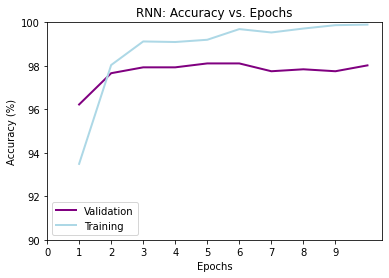

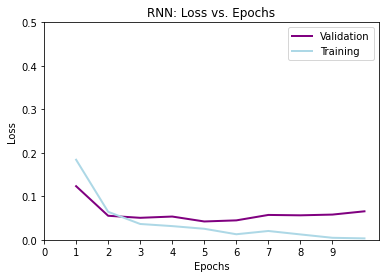

In [ ]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,N_EPOCHS+1), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,N_EPOCHS+1), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(1,N_EPOCHS+1), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.5))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

In [ ]:
_, test_accuracy = evaluate(lstm_model, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  98.19 %


Al pasar a un modelo LSTM, el cual incorpora células de memoria para mantener de forma más robusta información tanto antigua como reciente, podemos observar un leve incremento en la precisión sobre el set de test, un 1% de mejoría respecto a la red recurrente tradicional para este set de datos particulares.
Esto podría explicarse porque las últimas palabras de los SMS efectivamente tienen suficiente información para determinar su clase (terminan con frecuencia en un precio o un numero al cual llamar), si bien mantener al tanto las palabras iniciales aporta información, no es crucial para esta tarea en particular.
Si bien vemos un aumento en el rendimiento, el modelo también es más pesado en su cantidad de parámetros, al necesitar algunos para mantener memoria de largo plazo. El LSTM usa 226 mil parámetros, un 24% más comparado con su RNN homóloga de 182 mil parámetros, lo cual por su puesto tambien se refleja en el tiempo de entrenamiento.

###Actividad 5

In [ ]:
def train2(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 2
bidirection = False # set bidirection
dropout = 0

#instantiate the lstm model
deep_lstm = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(deep_lstm)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(deep_lstm):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
deep_lstm.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 100)
  (lstm): LSTM(100, 80, num_layers=2, batch_first=True)
  (fc): Linear(in_features=80, out_features=60, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 277,901 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3196, -0.0119,  0.0098,  ..., -0.0504,  0.2983,  1.3323],
        [ 0.5492,  0.1545, -0.6830,  ..., -1.2155,  0.5693,  1.0440],
        [-0.2009, -0.1691, -0.3587,  ..., -0.3249, -0.3411,  0.2473]])

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(deep_lstm.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the deep_lstm
    train_loss, train_acc = train2(deep_lstm, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the deep_lstm
    valid_loss, valid_acc = evaluate(deep_lstm, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.177 | Train Acc: 93.60%
	Val. Loss: 0.108 |  Val. Acc: 96.67%
Epoch: 2
	Train Loss: 0.057 | Train Acc: 98.50%
	Val. Loss: 0.062 |  Val. Acc: 97.57%
Epoch: 3
	Train Loss: 0.039 | Train Acc: 98.99%
	Val. Loss: 0.042 |  Val. Acc: 98.02%
Epoch: 4
	Train Loss: 0.023 | Train Acc: 99.46%
	Val. Loss: 0.045 |  Val. Acc: 97.93%
Epoch: 5
	Train Loss: 0.027 | Train Acc: 99.35%
	Val. Loss: 0.056 |  Val. Acc: 96.94%
Epoch: 6
	Train Loss: 0.022 | Train Acc: 99.43%
	Val. Loss: 0.044 |  Val. Acc: 98.02%
Epoch: 7
	Train Loss: 0.017 | Train Acc: 99.51%
	Val. Loss: 0.045 |  Val. Acc: 98.20%
Epoch: 8
	Train Loss: 0.013 | Train Acc: 99.61%
	Val. Loss: 0.046 |  Val. Acc: 97.93%
Epoch: 9
	Train Loss: 0.004 | Train Acc: 99.90%
	Val. Loss: 0.056 |  Val. Acc: 98.02%
Epoch: 10
	Train Loss: 0.003 | Train Acc: 99.90%
	Val. Loss: 0.056 |  Val. Acc: 98.11%


Para el LSTM con 2 capas, hay tres aspectos que llaman la atención. En primer lugar, hay un notorio aumento en la cantidad de parámetros, llegando a 277 mil. Esto da paso al segundo aspecto, que es la velocidad de convergencia del entrenamiento, si bien es considerablemente más lento que los otros modelos (dado el aumento de parámetros), el modelo necesita algunas pocas épocas para mostrar resultados robustos. Finalmente, cabe destacar que no se ve una clara mejoría en la precisión del modelo, probablemente porque la tarea de clasificar mensajes de texto es suficientemente simple como para que baste una capa oculta para modelarlo con la complejidad necesaria.

In [ ]:
#GloVe embeddings with 50 dims instead of 100
TEXT.build_vocab(train_data,min_freq=5, vectors = "glove.6B.50d")  # changed to 50
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 50
num_hidden_nodes = 80
num_output_nodes = 1
num_layers = 1
bidirection = True # set bidirection
dropout = 0

#instantiate the lstm model
bi_rnn = classifier2(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, 
                   bidirectional = bidirection, dropout = dropout)
print(bi_rnn)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(bi_rnn):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
bi_rnn.embedding.weight.data.copy_(pretrained_embeddings)

classifier2(
  (embedding): Embedding(1629, 50)
  (lstm): LSTM(50, 80, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=160, out_features=30, bias=True)
  (act0): ReLU(inplace=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
  (act1): Sigmoid()
)
The model has 170,791 trainable parameters


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 1.4680, -0.6181,  1.5910,  ...,  0.1525,  0.3721,  0.5773],
        [-0.2304, -0.0052, -1.4649,  ..., -1.1053, -0.7462,  0.2862],
        [ 0.0239, -0.3738, -0.1698,  ...,  0.0891,  0.3344, -0.4427]])

Finalmente para este último modelo tenemos un embedding de GloVe con 50 dimensiones (en vez de 100), una red recurrente bidireccional de 1 capa oculta, con un cambio en la dimension de su capa linear (de 60 a 30 dimensiones).

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

#define optimizer and loss
optimizer = optim.Adam(bi_rnn.parameters())
criterion = nn.BCELoss()

val_acc_hist = []
train_acc_hist = []
val_loss_hist = []
train_loss_hist = []
for epoch in range(N_EPOCHS):
     
    #train the bi_rnn
    train_loss, train_acc = train2(bi_rnn, train_iterator, optimizer, criterion)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    #evaluate the bi_rnn
    valid_loss, valid_acc = evaluate(bi_rnn, valid_iterator, criterion)
    val_loss_hist.append(valid_loss)
    val_acc_hist.append(valid_acc)

    print("Epoch:", epoch + 1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 1
	Train Loss: 0.185 | Train Acc: 93.16%
	Val. Loss: 0.103 |  Val. Acc: 95.59%
Epoch: 2
	Train Loss: 0.085 | Train Acc: 97.34%
	Val. Loss: 0.079 |  Val. Acc: 96.85%
Epoch: 3
	Train Loss: 0.057 | Train Acc: 98.19%
	Val. Loss: 0.063 |  Val. Acc: 97.12%
Epoch: 4
	Train Loss: 0.033 | Train Acc: 99.12%
	Val. Loss: 0.052 |  Val. Acc: 97.66%
Epoch: 5
	Train Loss: 0.030 | Train Acc: 99.23%
	Val. Loss: 0.049 |  Val. Acc: 97.93%
Epoch: 6
	Train Loss: 0.017 | Train Acc: 99.59%
	Val. Loss: 0.047 |  Val. Acc: 98.02%
Epoch: 7
	Train Loss: 0.013 | Train Acc: 99.61%
	Val. Loss: 0.052 |  Val. Acc: 97.93%
Epoch: 8
	Train Loss: 0.012 | Train Acc: 99.64%
	Val. Loss: 0.051 |  Val. Acc: 98.20%
Epoch: 9
	Train Loss: 0.013 | Train Acc: 99.69%
	Val. Loss: 0.041 |  Val. Acc: 98.38%
Epoch: 10
	Train Loss: 0.005 | Train Acc: 99.87%
	Val. Loss: 0.056 |  Val. Acc: 98.02%


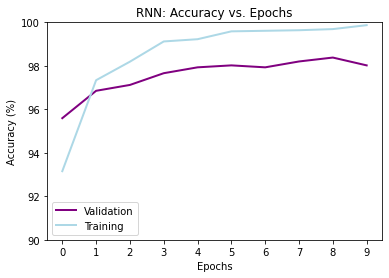

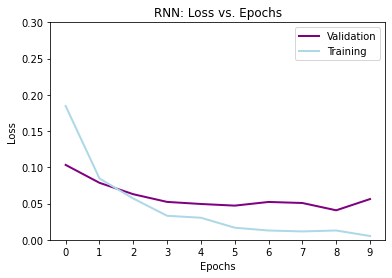

In [ ]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("RNN: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(0,N_EPOCHS), val_acc_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(0,N_EPOCHS), train_acc_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((90,100))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("RNN: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(0,N_EPOCHS), val_loss_history, label="Validation", color="purple", linewidth=2)
plt.plot(range(0,N_EPOCHS), train_loss_history, label="Training", color="lightblue", linewidth=2)
plt.ylim((0.0,0.3))
plt.xticks(np.arange(0, N_EPOCHS, 1))
plt.legend()
plt.show()

In [ ]:
_, test_accuracy = evaluate(bi_rnn, test_iterator, criterion)
print("Accuracy in Test set was: ", round(test_accuracy*100,2), "%")

Accuracy in Test set was:  98.19 %


Este último modelo presenta muy buenos resultados, llegando a una pérdida casi 0 en el set de test, y un 98% de precisión en set de validacion y de test. Si bien el número de parámetros disminuyó considerablemente (por la reducción de dimensiones a la mitad en el embedding), el tiempo de entrenamiento no fue menor a otros modelos, sin duda debido a la bidireccion, teniendo que pasar cada secuencia dos veces por la red.


##Parte 2

###Actividad 6 y 7

In [4]:
# config.py

class PathConfig:
    ROOT_DIR = my_dir
    DATA_DIR = ROOT_DIR + "data/"
    CACHE_DIR = ROOT_DIR + "cache/"
    MODEL_PATH = ROOT_DIR + "model/"

    SICK_FILE = DATA_DIR + "SICK.txt"
    W2V_FILE = DATA_DIR + "GoogleNews-vectors-negative300.bin.gz"

    RAW_SICK_CACHE = CACHE_DIR + "SICK.raw.cache"
    RAW_KES_CACHE = CACHE_DIR + "KES.raw.cache"
    SICK_CACHE = CACHE_DIR + "SICK.cache"
    KES_CACHE = CACHE_DIR + "KES.cache"

class NetworkConfig:
    EMBEDDING_DIM = 300
    HIDDEN_SIZE = 50
    BATCH_SIZE = 64
    EPOCH = 50

In [5]:
# utils.common 

import sys

class ProgressBar:
    def __init__(self, total, headline, bar_length=100):
        self.total = total
        self.bar_length = bar_length

        print(headline)

    def refresh(self, progress):
        percent = progress / self.total

        hashes = '#' * int(percent * self.bar_length)
        spaces = ' ' * (self.bar_length - len(hashes))

        sys.stdout.write("\r|%s[%.2f%%]%s| %s/%d" %
                         (hashes, percent * 100, spaces, str(progress).rjust(len(str(self.total))), self.total))
        sys.stdout.flush()

    def finish(self, report):
        print("\n%s (total: %d)\n" % (report, self.total))

In [ ]:
# utils.data

import abc
import re
import random
import numpy
import os
import pickle

from functools import reduce
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

#from config import PathConfig, NetworkConfig
#from utils.common import ProgressBar
#from utils.db import Db

import warnings
warnings.filterwarnings(action="ignore", category=UserWarning, module="gensim")
from gensim.models import KeyedVectors


class Data(metaclass=abc.ABCMeta):
    __data__ = {"train": [[], []],
                "test": [[], []],
                "validation": [[], []],
                "max_seq_len": 0,
                "embeddings": numpy.zeros(0)}

    @staticmethod
    def __text__cleaning__(text):
        text = str(text).lower()
        text = re.sub(r"[!@#$%^&*()\-_+=\[{\]};:'\",<.>/?\\|~]", " ", text)
        text = re.sub(r"\d+", " ", text)
        text = re.sub(r"[\n\r\t]", " ", text)
        text = re.sub(r"\ss\s", " ", text)
        text = re.sub(r"\sre\s", " ", text)
        text = re.sub(r"\sve\s", " ", text)
        text = re.sub(r"\sd\s", " ", text)
        text = re.sub(r"\sll\s", " ", text)
        text = re.sub(r"\sm\s", " ", text)
        text = re.sub(r"\st\s", " ", text)

        return text.strip()

    @classmethod
    def __load__cache__(cls, cache_path):
        if not os.path.exists(cache_path):
            return False

        with open(cache_path, "rb") as cache_file:
            cls.__data__ = pickle.load(cache_file)

        return True

    @classmethod
    def __cache__(cls, cache_path):
        with open(cache_path, "wb") as cache_file:
            print("Caching into %s..." % cache_path)
            pickle.dump(cls.__data__, cache_file)
            print("Cached.\n")

    @classmethod
    def __generate__(cls):
        print("Loading word2vec from '%s'..." % PathConfig.W2V_FILE)
        word2vec = KeyedVectors.load_word2vec_format(PathConfig.W2V_FILE, binary=True)
        print("Word2vec has been loaded.\n")

        stops = set(stopwords.words("english"))
        vocabulary = dict()
        inverse_vocabulary = ["<UNKNOWN>"]
        max_seq_len = 0

        bar = ProgressBar(len(cls.__data__["train"][1]) +
                          len(cls.__data__["test"][1]) +
                          len(cls.__data__["validation"][1]),
                          "Generating numeric inputs...")
        progress = 0

        for set_name in "train", "test", "validation":
            raw_X = cls.__data__[set_name][0]
            Y = cls.__data__[set_name][1]

            X = []
            for pair in raw_X:
                numerated_pair = []
                for sentence in pair:
                    numerated_sentence = []
                    word_list = sentence.split(" ")
                    for word in word_list:
                        if word in stops and word not in word2vec:
                            continue

                        if word not in vocabulary:
                            vocabulary[word] = len(inverse_vocabulary)
                            numerated_sentence.append(vocabulary[word])
                            inverse_vocabulary.append(word)
                        else:
                            numerated_sentence.append(vocabulary[word])
                    numerated_pair.append(numerated_sentence)

                    if len(numerated_sentence) > max_seq_len:
                        max_seq_len = len(numerated_sentence)

                progress += 1
                bar.refresh(progress)

                X.append(numerated_pair)

            cls.__data__[set_name] = [X, Y]
            cls.__data__["max_seq_len"] = max_seq_len

        bar.finish("Numeric inputs has been generated.")

        bar = ProgressBar(len(vocabulary), "Generating word embeddings...")
        progress = 0

        embeddings = 1 * numpy.random.randn(len(vocabulary) + 1, NetworkConfig.EMBEDDING_DIM)
        for word, index in vocabulary.items():
            progress += 1
            bar.refresh(progress)
            if word in word2vec:
                embeddings[index] = word2vec[word]
        embeddings[0] = 0
        cls.__data__["embeddings"] = embeddings

        bar.finish("Word embeddings has been generated.")

    @abc.abstractmethod
    def load(self):
        return self

    @abc.abstractmethod
    def generate(self):
        return None

    @staticmethod
    def batches(data):
        X, Y = data[0], data[1]
        for i in range(0, len(X), NetworkConfig.BATCH_SIZE):
            remaining = len(X) - i
            if remaining < NetworkConfig.BATCH_SIZE:
                X_supplement = [[[0], [0]] for _ in range(NetworkConfig.BATCH_SIZE - remaining)]
                Y_supplement = [1.0 for _ in range(NetworkConfig.BATCH_SIZE - remaining)]
                batch = [X[i:] + X_supplement, Y[i:] + Y_supplement]
            else:
                batch = [X[i: i + NetworkConfig.BATCH_SIZE], Y[i: i + NetworkConfig.BATCH_SIZE]]
            yield batch


class SICK(Data):
    @classmethod
    def load(cls):
        if cls.__load__cache__(PathConfig.RAW_SICK_CACHE):
            print("Raw SICK data cache has been loaded from %s\n" % PathConfig.RAW_SICK_CACHE)
            return cls

        with open(PathConfig.SICK_FILE, "r", encoding="utf-8") as SICK_file:
            lines = SICK_file.readlines()
            bar = ProgressBar(len(lines) - 1, "Loading raw SICK data...")
            progress = 0

            for line in lines[1:]:
                elements = line.split("\t")
                sentence_A, sentence_B, relatedness_score = \
                    cls.__text__cleaning__(elements[1]), cls.__text__cleaning__(elements[2]), float(elements[4])
                chance = random.randint(0,100)
                #SemEval_set = "validation" if elements[11].strip() == "TRIAL" else elements[11].strip().lower()
                if chance <= 70:
                  SemEval_set = "train"
                elif 90 >= chance > 70:
                  SemEval_set = "validation"
                elif chance > 90:
                  SemEval_set = "test"

                cls.__data__[SemEval_set][0].append((sentence_A, sentence_B))
                cls.__data__[SemEval_set][1].append(relatedness_score / 5)

                progress += 1
                bar.refresh(progress)

        bar.finish("Raw SICK data has been loaded.")
        cls.__cache__(PathConfig.RAW_SICK_CACHE)

        return cls

    @classmethod
    def generate(cls):
        if cls.__load__cache__(PathConfig.SICK_CACHE):
            print("Numeric SICK inputs cache has been loaded from %s\n" % PathConfig.SICK_CACHE)
            return cls.__data__

        cls.__generate__()
        cls.__cache__(PathConfig.SICK_CACHE)

        return cls.__data__


In [7]:
# network.py

import torch
import copy
import time
import numpy

from enum import Enum
from math import ceil
#from config import PathConfig, NetworkConfig
#from utils.data import Data
#from utils.common import ProgressBar


class MaLSTM(torch.nn.Module):
    @staticmethod
    def exponent_neg_manhattan_distance(left, right):
        pairwise_distance = torch.nn.PairwiseDistance(p=1).cuda()
        return torch.exp(-pairwise_distance(left, right)).cuda()

    def __init__(self, max_seq_len, embeddings):
        super(MaLSTM, self).__init__()

        self.max_seq_len = max_seq_len

        self.embedding_layer = torch.nn.Embedding(len(embeddings), NetworkConfig.EMBEDDING_DIM).cuda()
        self.embedding_layer.weight.data.copy_(torch.from_numpy(embeddings))
        self.embedding_layer.weight.requires_grad = False

        self.left_hidden_layer = torch.nn.LSTM(input_size=NetworkConfig.EMBEDDING_DIM,
                                               hidden_size=NetworkConfig.HIDDEN_SIZE).cuda()
        self.right_hidden_layer = torch.nn.LSTM(input_size=NetworkConfig.EMBEDDING_DIM,
                                                hidden_size=NetworkConfig.HIDDEN_SIZE).cuda()

    def padding_input(self, rand_len_inputs):
        padded = []
        for rand_len_input in rand_len_inputs:
            padding_len = self.max_seq_len - len(rand_len_input)
            padding = [0 for _ in range(padding_len)]
            padded.append(padding + rand_len_input)
        return torch.LongTensor(padded).cuda()

    def forward(self, X_batch):
        left_input = [X_batch[i][0] for i in range(NetworkConfig.BATCH_SIZE)]
        right_input = [X_batch[i][1] for i in range(NetworkConfig.BATCH_SIZE)]

        encoded_left_input = self.embedding_layer(self.padding_input(left_input))
        encoded_right_input = self.embedding_layer(self.padding_input(right_input))

        _, (left_h, _) = self.left_hidden_layer(encoded_left_input.view(self.max_seq_len,
                                                                        NetworkConfig.BATCH_SIZE,
                                                                        NetworkConfig.EMBEDDING_DIM))
        _, (right_h, _) = self.right_hidden_layer(encoded_right_input.view(self.max_seq_len,
                                                                           NetworkConfig.BATCH_SIZE,
                                                                           NetworkConfig.EMBEDDING_DIM))
        #print("Left hidden:")
        #print("Shape", left_h.shape)
        #print("type", type(left_h))
        #print("Shape 0", left_h[0].shape)
        #print("type 0", type(left_h[0]))
        return MaLSTM.exponent_neg_manhattan_distance(left_h[0], right_h[0])


class Network:
    class Phase(Enum):
        TRAIN = 1
        TRIAL = 2

        def __str__(self):
            if self is Network.Phase.TRAIN:
                return "train"
            else:
                return "validation"

    def __init__(self, model, loss_function, optimizer, data, lr_scheduler=None):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.data = data
        self.lr_scheduler = lr_scheduler

    @staticmethod
    def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, decay_every=8):
        lr = init_lr * (0.1 ** (epoch // decay_every))

        if epoch % decay_every == 0:
            print("Learning rate has been set to %f" % lr)

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        return optimizer

    def optimize(self, save_name=None):
        best_model = self.model
        min_loss = float("inf")

        total = 0
        for phase in Network.Phase:
            total += NetworkConfig.EPOCH * \
                     ceil(len(self.data[str(phase)][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
        bar = ProgressBar(total, "Training model...")
        progress = 0

        val_acc_hist = []
        train_acc_hist = []
        val_loss_hist = []
        train_loss_hist = []
        for epoch in range(NetworkConfig.EPOCH):
            for phase in Network.Phase:
                if phase is Network.Phase.TRAIN:
                    if self.lr_scheduler:
                        self.model = self.lr_scheduler(self.model, NetworkConfig.EPOCH)
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                total = ceil(len(self.data[str(phase)][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
                correct_count = 0

                for batch in Data.batches(self.data[str(phase)]):
                    self.optimizer.zero_grad()

                    X, Y = batch[0], torch.Tensor(batch[1]).cuda()
                    #print("Datos:", type(X), X[0], X)
                    output = self.model(X) # aca seria output1, output2 = self.model(X)
                    #print("Output:", output.shape, output[0], output)
                    #print("Targets:", Y.shape, Y[0], Y)
                    loss = self.loss_function(output, Y)
                    #print("Loss:", type(loss), loss)

                    output = numpy.round(output.cpu().detach().numpy() * 5)
                    Y = numpy.round(numpy.array(Y.cpu()) * 5)
                    correct_count += numpy.sum(output == Y)

                    if phase is Network.Phase.TRAIN:
                        loss.backward()
                        self.optimizer.step()

                    progress += NetworkConfig.BATCH_SIZE
                    bar.refresh(progress)

                    running_loss += loss.data.cpu().numpy()
                    #correct_count += numpy.sum(output == Y)

                epoch_loss = running_loss / len(self.data[str(phase)])
                epoch_acc = correct_count / total
                if phase is Network.Phase.TRAIN:
                  train_loss_hist.append(epoch_loss)
                  train_acc_hist.append(epoch_acc)
                if phase is Network.Phase.TRIAL:
                  val_loss_hist.append(epoch_loss)
                  val_acc_hist.append(epoch_acc)

                if phase is Network.Phase.TRIAL and epoch_loss < min_loss:
                    best_model = copy.deepcopy(self.model)
                    min_loss = epoch_loss

        bar.finish("Model has been optimized in %d epochs with %f as its minimal loss."
                   % (NetworkConfig.EPOCH, min_loss))

        if save_name is None:
            save_name = time.strftime("%Y%m%d_%H%M%S")
        save_path = "%s%s.mdl" % (PathConfig.MODEL_PATH, save_name)
        print("[SKIPPED] Saving model into %s..." % save_path)
        #torch.save(best_model, save_path)
        #print("Saved.\n")

        self.model = best_model

        return val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist

    def evaluate(self, save_name=None):
        if save_name is None:
            model = self.model.cuda()
        else:
            save_path = "%s%s.mdl" % (PathConfig.MODEL_PATH, save_name)
            print("Loading model from %s..." % save_path)
            model = torch.load(save_path).cuda()
            print("Loaded.\n")

        total = ceil(len(self.data["test"][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
        correct_count = 0

        bar = ProgressBar(total, "Testing model...")
        progress = 0

        for batch in Data.batches(self.data["test"]):
            X, Y = batch[0], batch[1]
            output = model(X)

            output = numpy.array(output.cpu().detach().numpy()) * 5 #numpy.round(output.cpu().detach().numpy() * 5)
            Y = numpy.array(Y) * 5 #numpy.round(numpy.array(Y) * 5)
            #print(type(output), output)
            #print(type(Y), Y)
            for i in range(len(output)):
              if Y[i]*0.8 <= output[i] <= Y[i]*1.2 :
                correct_count += 1
            #correct_count += numpy.sum(output == Y)

            progress += NetworkConfig.BATCH_SIZE
            bar.refresh(progress)

        bar.finish("Accuracy: %f" % (correct_count / total))

In [8]:
# load SICK dataset and Word2Vec embedding
sick = SICK.load().generate()
print("Data:", sick["train"][0][:2]) # lista de listas con dos elementos, correspondientes a pares frase con sus palabras pasadas a indices
print("labels", sick["train"][1][:2]) # labels correspondientes, numero del 0 al 1, (escalado desde 0 a 5) representa el % de similitud semántica
print("Training data: ", len(sick["train"][0]))
print("Validation data: ", len(sick["validation"][0]))
print("Test data: ", len(sick["test"][0]))


Raw SICK data cache has been loaded from /content/drive/MyDrive/DL/T2/cache/SICK.raw.cache

Numeric SICK inputs cache has been loaded from /content/drive/MyDrive/DL/T2/cache/SICK.cache

Data: [[[1, 2, 3, 4, 5, 6, 7, 8, 3, 9, 10, 11, 5, 6, 12], [1, 13, 3, 4, 5, 14, 15, 16, 10, 3, 11, 5, 6, 12]], [[6, 17, 18, 19, 4, 20, 6, 10, 3, 21, 22], [6, 13, 19, 4, 20, 23, 10, 24, 25]]]
labels [0.64, 0.9400000000000001]
Training data:  6885
Validation data:  2006
Test data:  949


El dataset de SICK, contiene un total de 9.927 entradas que corresponden a pares de frases rotuladas. Cada par de frases tiene un label que indica qué tan relacionadas están ambas oraciones en su significado, mediante un número continuo del 1 al 5. Este número fue obtenido mediante el promedio de puntuaciones de relación indicadas por 10 personas diferentes para cada par de frases. SICK contiene más rótulos (por ejemplo, estableciendo si las oraciones son contradictorias, neutrales, o concordantes), sin embargo estos no son utilizados para entrenar esta red siamesa.

Además, Mueller et al. expanden el dataset empleando Data Augmentation, logrando duplicar aproximadamente la cantidad de datos originales al agregar 10.022 entradas adicionales. Esto se obtiene reemplazando palabras aleatorias con alguno de sus sinónimos presentes en WordNet. Para el entrenamiento, usan 70% de los datos, dejando un 30% para validar sus resultados.

In [9]:
# instance model
import torch

model = MaLSTM(sick["max_seq_len"], sick["embeddings"])
print(model)

def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The model has {} parameters".format(num_trainable_parameters(model)))

loss_function = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adadelta(model.parameters())
network = Network(model, loss_function, optimizer, sick)

MaLSTM(
  (embedding_layer): Embedding(2305, 300)
  (left_hidden_layer): LSTM(300, 50)
  (right_hidden_layer): LSTM(300, 50)
)
The model has 140800 parameters


In [82]:
#Train model

val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist = network.optimize()

Training model...
|####################################################################################################[100.00%]| 448000/448000
Model has been optimized in 50 epochs with 1.207320 as its minimal loss. (total: 448000)

[SKIPPED] Saving model into /content/drive/MyDrive/DL/T2/model/20210607_235823.mdl...


In [83]:
#Test model

network.evaluate()

Testing model...
|####################################################################################################[100.00%]| 960/960
Accuracy: 0.244792 (total: 960)



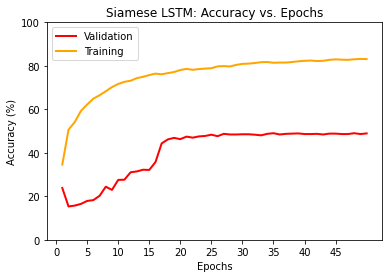

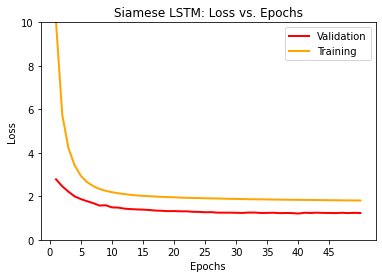

In [84]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist]
train_acc_history = [h*100 for h in train_acc_hist]

plt.title("Siamese LSTM: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,NetworkConfig.EPOCH+1), val_acc_history, label="Validation", color="red", linewidth=2)
plt.plot(range(1,NetworkConfig.EPOCH+1), train_acc_history, label="Training", color="orange", linewidth=2)
plt.ylim((0,100))
plt.xticks(np.arange(0, NetworkConfig.EPOCH, 5))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist]
train_loss_history = [h for h in train_loss_hist]

plt.title("Siamese LSTM: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NetworkConfig.EPOCH+1), val_loss_history, label="Validation", color="red", linewidth=2)
plt.plot(range(1,NetworkConfig.EPOCH+1), train_loss_history, label="Training", color="orange", linewidth=2)
plt.ylim((0,10))
plt.xticks(np.arange(0, NetworkConfig.EPOCH, 5))
plt.legend()
plt.show()

El modelo resultante cuenta con 140.800 parámetros, lo que es una cantidad menor a la utilizada en modelos anteriores, principalmente porque solo cuenta con una capa sin bidireccionalidad ni capas lineares densas. El embedding proveniente de Word2Vec genera la pirmera capa, la cual entrega un encoding de 300 dimensiones. Este tensor entra tanto al LSTM izquierdo, como al derecho, los cuales se encuentran con sus pesos atados y producen un output para la funcion de pérdida.

Para este caso, la métrica de pérdida es Error cuadrático medio (MSELoss), con lo que alcanzamos un 1.2 de pérdida aprox. y una precisión cercana al 24%, esta métrica de rendimiento es debatible puesto que al calcularla se toman en cuenta solo los resultados iguales al número esperado, sin embargo fallando por un rango aceptable, el resultado sigue siendo útil. Podemos intuir de cualquier forma, que la red está aprendiendo de memoria los ejemplos, dado que su rendimiento en el set de test esta muy por sobre su rendimiento en validación o test.

En la siguiente sección se construye una función de pérdida personalizada para probarla con el modelo


In [11]:
# network.py

import torch
import copy
import time
import numpy

from enum import Enum
from math import ceil
#from config import PathConfig, NetworkConfig
#from utils.data import Data
#from utils.common import ProgressBar


class MaLSTM2(torch.nn.Module):
    @staticmethod
    def exponent_neg_manhattan_distance(left, right):
        pairwise_distance = torch.nn.PairwiseDistance(p=1).cuda()
        return torch.exp(-pairwise_distance(left, right)).cuda()

    def __init__(self, max_seq_len, embeddings):
        super(MaLSTM2, self).__init__()

        self.max_seq_len = max_seq_len

        self.embedding_layer = torch.nn.Embedding(len(embeddings), NetworkConfig.EMBEDDING_DIM).cuda()
        self.embedding_layer.weight.data.copy_(torch.from_numpy(embeddings))
        self.embedding_layer.weight.requires_grad = False

        self.left_hidden_layer = torch.nn.LSTM(input_size=NetworkConfig.EMBEDDING_DIM,
                                               hidden_size=NetworkConfig.HIDDEN_SIZE).cuda()
        self.right_hidden_layer = torch.nn.LSTM(input_size=NetworkConfig.EMBEDDING_DIM,
                                                hidden_size=NetworkConfig.HIDDEN_SIZE).cuda()

    def padding_input(self, rand_len_inputs):
        padded = []
        for rand_len_input in rand_len_inputs:
            padding_len = self.max_seq_len - len(rand_len_input)
            padding = [0 for _ in range(padding_len)]
            padded.append(padding + rand_len_input)
        return torch.LongTensor(padded).cuda()

    def forward(self, X_batch):
        left_input = [X_batch[i][0] for i in range(NetworkConfig.BATCH_SIZE)]
        right_input = [X_batch[i][1] for i in range(NetworkConfig.BATCH_SIZE)]

        encoded_left_input = self.embedding_layer(self.padding_input(left_input))
        encoded_right_input = self.embedding_layer(self.padding_input(right_input))

        _, (left_h, _) = self.left_hidden_layer(encoded_left_input.view(self.max_seq_len,
                                                                        NetworkConfig.BATCH_SIZE,
                                                                        NetworkConfig.EMBEDDING_DIM))
        _, (right_h, _) = self.right_hidden_layer(encoded_right_input.view(self.max_seq_len,
                                                                           NetworkConfig.BATCH_SIZE,
                                                                           NetworkConfig.EMBEDDING_DIM))
        #print("Left hidden:")
        #print("Shape", left_h.shape)
        #print("type", type(left_h))
        #print("Shape 0", left_h[0].shape)
        #print("type 0", type(left_h[0]))
        return left_h[0], right_h[0]


class Network:
    class Phase(Enum):
        TRAIN = 1
        TRIAL = 2

        def __str__(self):
            if self is Network.Phase.TRAIN:
                return "train"
            else:
                return "validation"

    def __init__(self, model, loss_function, optimizer, data, lr_scheduler=None):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.data = data
        self.lr_scheduler = lr_scheduler

    @staticmethod
    def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, decay_every=8):
        lr = init_lr * (0.1 ** (epoch // decay_every))

        if epoch % decay_every == 0:
            print("Learning rate has been set to %f" % lr)

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        return optimizer

    def optimize(self, save_name=None):
        best_model = self.model
        min_loss = float("inf")

        total = 0
        for phase in Network.Phase:
            total += NetworkConfig.EPOCH * \
                     ceil(len(self.data[str(phase)][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
        bar = ProgressBar(total, "Training model...")
        progress = 0

        val_acc_hist = []
        train_acc_hist = []
        val_loss_hist = []
        train_loss_hist = []
        for epoch in range(NetworkConfig.EPOCH):
            for phase in Network.Phase:
                if phase is Network.Phase.TRAIN:
                    if self.lr_scheduler:
                        self.model = self.lr_scheduler(self.model, NetworkConfig.EPOCH)
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                total = ceil(len(self.data[str(phase)][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
                correct_count = 0

                for batch in Data.batches(self.data[str(phase)]):
                    self.optimizer.zero_grad()

                    X, Y = batch[0], torch.Tensor(batch[1]).cuda()
                    #print("Datos:", type(X), X[0], X)
                    output_left, output_right = self.model(X)
                    #print("Output:", output.shape, output[0], output)
                    #print("Targets:", Y.shape, Y[0], Y)
                    loss = self.loss_function(output_left, output_right, Y)
                    #print("Loss:", type(loss), loss)

                    output = self.model.exponent_neg_manhattan_distance(output_left, output_right)
                    output = numpy.round(output.cpu().detach().numpy() * 5)
                    Y = numpy.round(numpy.array(Y.cpu()) * 5)
                    correct_count += numpy.sum(output == Y)

                    if phase is Network.Phase.TRAIN:
                        loss.backward()
                        self.optimizer.step()

                    progress += NetworkConfig.BATCH_SIZE
                    bar.refresh(progress)

                    running_loss += loss#.data.cpu().numpy()
                    correct_count += numpy.sum(output == Y)

                epoch_loss = running_loss # / len(self.data[str(phase)])
                #print("EP Loss: ", epoch, epoch_loss)
                epoch_acc = correct_count / total
                if phase is Network.Phase.TRAIN:
                  train_loss_hist.append(epoch_loss)
                  train_acc_hist.append(epoch_acc)
                if phase is Network.Phase.TRIAL:
                  val_loss_hist.append(epoch_loss)
                  val_acc_hist.append(epoch_acc)

                if phase is Network.Phase.TRIAL and epoch_loss < min_loss:
                    best_model = copy.deepcopy(self.model)
                    min_loss = epoch_loss

        bar.finish("Model has been optimized in %d epochs with %f as its minimal loss."
                   % (NetworkConfig.EPOCH, min_loss))

        if save_name is None:
            save_name = time.strftime("%Y%m%d_%H%M%S")
        save_path = "%s%s.mdl" % (PathConfig.MODEL_PATH, save_name)
        print("[SKIPPED] Saving model into %s..." % save_path)
        #torch.save(best_model, save_path)
        #print("Saved.\n")

        self.model = best_model

        return val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist

    def evaluate(self, save_name=None):
        if save_name is None:
            model = self.model.cuda()
        else:
            save_path = "%s%s.mdl" % (PathConfig.MODEL_PATH, save_name)
            print("Loading model from %s..." % save_path)
            model = torch.load(save_path).cuda()
            print("Loaded.\n")

        total = ceil(len(self.data["test"][0]) / NetworkConfig.BATCH_SIZE) * NetworkConfig.BATCH_SIZE
        correct_count = 0

        bar = ProgressBar(total, "Testing model...")
        progress = 0

        for batch in Data.batches(self.data["test"]):
            X, Y = batch[0], batch[1]
            output_left, output_right = model(X)
            output = self.model.exponent_neg_manhattan_distance(output_left, output_right)

            output = numpy.array(output.cpu().detach().numpy()) * 5 #numpy.round(output.cpu().detach().numpy() * 5)
            Y = numpy.array(Y) * 5 #numpy.round(numpy.array(Y) * 5)
            #print(type(output), output)
            #print(type(Y), Y)
            for i in range(len(output)):
              if Y[i]*0.8 <= output[i] <= Y[i]*1.2 :
                correct_count += 1
            #correct_count += numpy.sum(output == Y)

            progress += NetworkConfig.BATCH_SIZE
            bar.refresh(progress)

        bar.finish("Accuracy: %f" % (correct_count / total))

In [12]:
import torch

# Define loss fn

class PairwiseRankingLoss(torch.nn.Module):
  """ Custom Pairwise Ranking Loss function"""
  def __init__(self):
    super(PairwiseRankingLoss, self).__init__()

  def forward(self, f1, f2, Y):
    """
    f1 and f2 are batches of vectors (64x50) 
    corresponding to LSTM output of left and right side.
    Y is a batch of scalar labels (64x1)
    """
    M = 0.001 # desired distance between similar elements
    norm_calculator = torch.nn.PairwiseDistance().cuda()
    vector_distance = norm_calculator(f1, f2) # tensor with shape 64x1
    Y_copy = Y

    # since relatedness values are discrete and not binary,
    # values are extremed, but formula still works for values not equal to 0 or 1
    # the idea is that a percentage of each metric is added
    Y_copy[Y_copy >= 0.8] = 1
    Y_copy[Y_copy < 0.2] = 0
    batch_loss = Y_copy * vector_distance + (1-Y_copy) * torch.maximum(torch.zeros(64).cuda(), M - vector_distance)
    scalar_loss = torch.mean(batch_loss)
    return scalar_loss

In [13]:
# instance custom loss model
import torch

pwr_model = MaLSTM2(sick["max_seq_len"], sick["embeddings"])
print(pwr_model)

def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The model has {} parameters".format(num_trainable_parameters(pwr_model)))

new_loss_function = PairwiseRankingLoss() # NEW LOSS FUNC
optimizer = torch.optim.Adadelta(pwr_model.parameters())
network3 = Network(pwr_model, new_loss_function, optimizer, sick)

MaLSTM2(
  (embedding_layer): Embedding(2305, 300)
  (left_hidden_layer): LSTM(300, 50)
  (right_hidden_layer): LSTM(300, 50)
)
The model has 140800 parameters


In [14]:
#Train new model

val_acc_hist1, train_acc_hist1, val_loss_hist1, train_loss_hist1 = network3.optimize()

Training model...
|####################################################################################################[100.00%]| 448000/448000
Model has been optimized in 50 epochs with 0.161309 as its minimal loss. (total: 448000)

[SKIPPED] Saving model into /content/drive/MyDrive/DL/T2/model/20210608_024826.mdl...


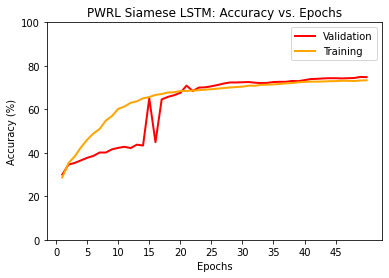

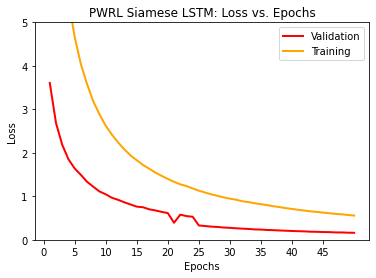

In [15]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

val_acc_history = [h*100 for h in val_acc_hist1]
train_acc_history = [h*100 for h in train_acc_hist1]

plt.title("PWRL Siamese LSTM: Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(range(1,NetworkConfig.EPOCH+1), val_acc_history, label="Validation", color="red", linewidth=2)
plt.plot(range(1,NetworkConfig.EPOCH+1), train_acc_history, label="Training", color="orange", linewidth=2)
plt.ylim((0,100))
plt.xticks(np.arange(0, NetworkConfig.EPOCH, 5))
plt.legend()
plt.show()

val_loss_history = [h for h in val_loss_hist1]
train_loss_history = [h for h in train_loss_hist1]

plt.title("PWRL Siamese LSTM: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NetworkConfig.EPOCH+1), val_loss_history, label="Validation", color="red", linewidth=2)
plt.plot(range(1,NetworkConfig.EPOCH+1), train_loss_history, label="Training", color="orange", linewidth=2)
plt.ylim((0,5))
plt.xticks(np.arange(0, NetworkConfig.EPOCH, 5))
plt.legend()
plt.show()

In [16]:
#Test model

network3.evaluate()

Testing model...
|####################################################################################################[100.00%]| 960/960
Accuracy: 0.369792 (total: 960)



Al implementar la nueva función de pérdida personalizada: Pairwise Ranking Loss, podemos ver que el modelo mejora su rendimiento al presentar una pérdida cercana a 0.16 al final de su entrenamiento, y 13 puntos porcentuales de mejoría en su precisión al enfrentarse al set de test. Con esto podemos evidenciar lo importante que es una correcta métrica de evaluación para un modelo de aprendizaje profundo.

##Referencias
1. *Kaggle GloVe distribution*. Disponible en: https://www.kaggle.com/anindya2906/glove6b

2. *AnalyticsVidhya*. Disponible en: https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

3. *Pytorch RNN tutorial*. Disponible en: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

4. *J. Mueller, A. Thyagarajan.  Siamese Recurrent Architectures for Learning Sentence Similarity. In AAAI-16, 2016.*

6. *Guideline on Siamese LSTM implementation using PyTorch*. Disponible en: https://github.com/buxcon/siamese_lstm/

5. *Pytorch Official Documentation*. Disponible en: https://pytorch.org/docs/stable/index.html